# Dataset cleanup

## Biblioteki

In [0]:
# Put these at the top of every notebook, to get automatic reloading
%reload_ext autoreload
%autoreload 2

#matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots_wcz import *

from pathlib import Path

from  collections import Counter

from sklearn.metrics import confusion_matrix

## Mój dataset: 'Old Polish Cars v4'

In [0]:
dataset_path = Path('/content/data/old_polish_cars')
PATH = dataset_path / 'old_polish_cars_v5_photos-split/'

In [3]:
ls -lah $dataset_path

total 4.8G
drwxr-xr-x  4 root      root      4.0K Apr 28 20:06 ./
drwxr-xr-x  3 root      root      4.0K Apr 28 16:32 ../
drwxr-xr-x 12 349452163 349400513 4.0K Apr 28 19:09 old_polish_cars_v4_photos/
-rw-r--r--  1 root      root      2.4G Apr 28 20:06 old_polish_cars_v4_photos-20180428.tgz
drwxr-xr-x  7 349452163 349400513 4.0K Apr  9 21:23 old_polish_cars_v5_photos-split/
-rw-r--r--  1 root      root      2.4G Apr 28 20:14 old_polish_cars_v5_photos-split-2017-11-15.tgz


In [4]:
ls $PATH/train

Autobus Jelcz MZK/     Fiat 126p Maluch/  FSO Warszawa/  ZSD Nysa/
Autobus Jelcz Ogorek/  FSC Zuk/           Gazik/
Fiat 125p/             FSO Polonez/       Syrena 105/


In [0]:
cleanup_dataset_path = dataset_path / 'old_polish_cars_v4_photos/'

In [27]:
cats = sorted(list([x.stem for x in cleanup_dataset_path.iterdir()])); cats

['Autobus Jelcz MZK',
 'Autobus Jelcz Ogorek',
 'FSC Zuk',
 'FSO Polonez',
 'FSO Warszawa',
 'Fiat 125p',
 'Fiat 126p Maluch',
 'Gazik',
 'Syrena 105',
 'ZSD Nysa']

In [7]:
cats_dict = {cat: idx for idx, cat in enumerate(cats)}; cats_dict

{'Autobus Jelcz MZK': 0,
 'Autobus Jelcz Ogorek': 1,
 'FSC Zuk': 2,
 'FSO Polonez': 3,
 'FSO Warszawa': 4,
 'Fiat 125p': 5,
 'Fiat 126p Maluch': 6,
 'Gazik': 7,
 'Syrena 105': 8,
 'ZSD Nysa': 9}

# Kategoria

In [0]:
#@title Kategoria
selected_cat = "ZSD Nysa" #@param ['Autobus Jelcz MZK', 'Autobus Jelcz Ogorek', 'FSC Zuk', 'FSO Polonez', 'FSO Warszawa', 'Fiat 125p', 'Fiat 126p Maluch', 'Gazik', 'Syrena 105', 'ZSD Nysa']


In [37]:
# selected_cat = 'ZSD Nysa'
selected_cat_idx = cats_dict[selected_cat]
selected_cat_path = cleanup_dataset_path / cats[selected_cat_idx]; print(selected_cat_path)

print('{} items'.format(len(list(selected_cat_path.iterdir()))))

/content/data/old_polish_cars/old_polish_cars_v4_photos/ZSD Nysa
637 items


## Model

In [38]:
sz=224
arch=resnet34

tfms = tfms_from_model(arch, sz)

data = ImageClassifierData.from_paths(PATH, test_name=selected_cat_path, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [0]:
learn.precompute=False
# learn.load('224_lastlayer')
learn.load('224_all')

## Predykcja z zawartości foldera

In [0]:
log_preds = learn.predict(is_test=True)

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds);            # pr(car)
selected_y = np.full_like(preds, selected_cat_idx) #; selected_y[:10]

preds_classes = [data.classes[pred] for pred in preds] #; preds_classes[:10]
cat_classes = sorted(list(set(preds))) #; cat_classes

In [41]:
probs[:10]

array([[0.     , 0.00002, 0.00006, 0.     , 0.00002, 0.     , 0.     , 0.00001, 0.00001, 0.99988],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.     , 0.00056, 0.00041, 0.     , 0.     , 0.00002, 0.     , 0.00001, 0.     , 0.999  ],
       [0.     , 0.00005, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.99995],
       [0.56352, 0.22647, 0.11695, 0.01991, 0.00117, 0.0157 , 0.0115 , 0.00514, 0.00264, 0.03699],
       [0.00046, 0.0013 , 0.00179, 0.01713, 0.01102, 0.00249, 0.01672, 0.92041, 0.0243 , 0.00439],
       [0.     , 0.00001, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.99997],
       [0.     , 0.00053, 0.00043, 0.     , 0.     , 0.     , 0.     , 0.00001, 0.     , 0.99902],
       [0.00015, 0.00599, 0.00004, 0.     , 0.00001, 0.00035, 0.00001, 0.00002, 0.00001, 0.99342],
       [0.00001, 0.     , 0.00057, 0.     , 0.00003, 0.00001, 0.     , 0.00015, 0.00001, 0.99922]],
      dty

In [42]:
pred_probs = np.array([(pred, probs[pred]) for pred,probs in zip(preds, probs)]); pred_probs[:10]

array([[9.     , 0.99988],
       [9.     , 1.     ],
       [9.     , 0.999  ],
       [9.     , 0.99995],
       [0.     , 0.56352],
       [7.     , 0.92041],
       [9.     , 0.99997],
       [9.     , 0.99902],
       [9.     , 0.99342],
       [9.     , 0.99922]])

In [43]:
accuracy_np(probs, selected_y)

0.869701726844584

In [44]:
Counter(preds_classes)

Counter({'Autobus Jelcz MZK': 5,
         'Autobus Jelcz Ogorek': 11,
         'FSC Zuk': 16,
         'FSO Polonez': 5,
         'FSO Warszawa': 7,
         'Fiat 125p': 15,
         'Fiat 126p Maluch': 4,
         'Gazik': 9,
         'Syrena 105': 11,
         'ZSD Nysa': 554})

## Tablica pomyłek

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  5  11  16   5   7  15   4   9  11 554]]


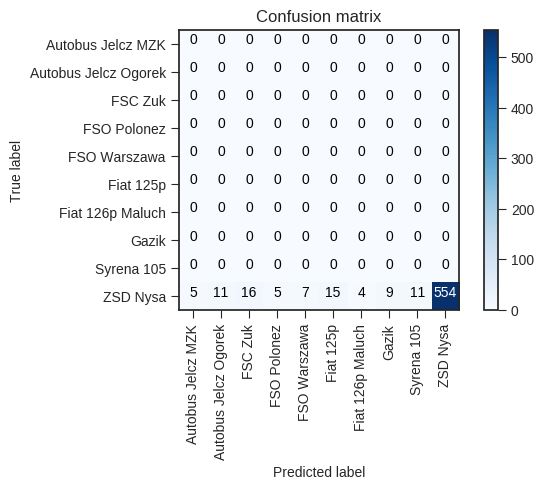

In [45]:
cm = confusion_matrix(selected_y, preds)

mpl.style.use('default')
mpl.style.use('seaborn-ticks')

# %config InlineBackend.figure_format = 'retina'

plot_confusion_matrix(cm, [data.classes[cat] for cat in cat_classes]) # WAS: data.classes

## Przegląd zdjęć

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == selected_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH/ds.fnames[idx]))

def plot_val_with_title(idxs, title):  
    imgs = [load_img_id(data.test_ds,x) for x in idxs]
    def fn(x): return Path(data.test_ds.fnames[x]).stem
    def pred_str(x): return '' + data.classes[int(pred_probs[x, 0])] + f', {pred_probs[x, 1]*100:0.4}%'
    title_probs = [pred_str(x) for x in idxs]
    titles = [f'{fn(x)} -> {pred_str(x)}' for x in idxs]
    print(title)
    print(titles)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified
['ZSD.Nysa.521.000197 -> ZSD Nysa, 98.33%', 'ZSD.Nysa.521.000344 -> ZSD Nysa, 100.0%', 'ZSD.Nysa.501.000519 -> ZSD Nysa, 100.0%', 'ZSD.Nysa.501.000147 -> ZSD Nysa, 100.0%']


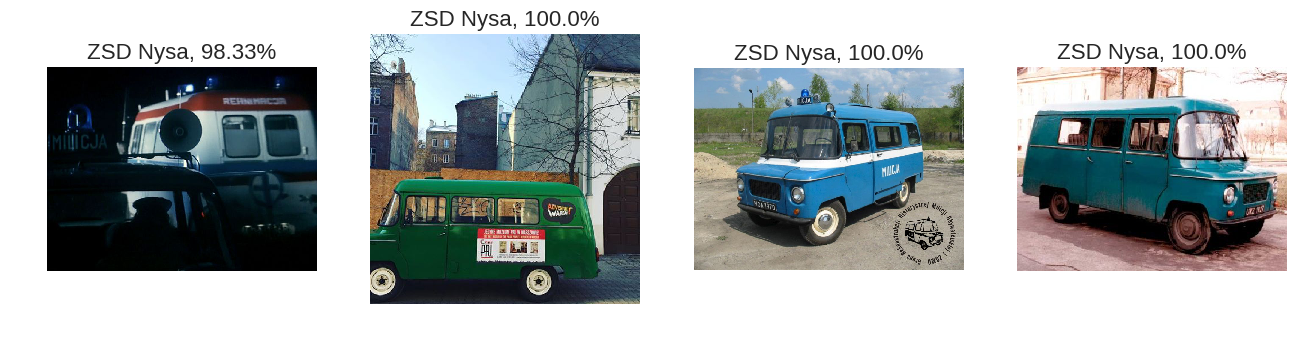

In [49]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified
['ZSD.Nysa.501.000250 -> Syrena 105, 99.99%', 'ZSD.Nysa.521.000235 -> Fiat 125p, 99.2%', 'ZSD.Nysa.501.000094 -> Fiat 126p Maluch, 90.41%', 'ZSD.Nysa.521.000166 -> FSC Zuk, 99.08%']


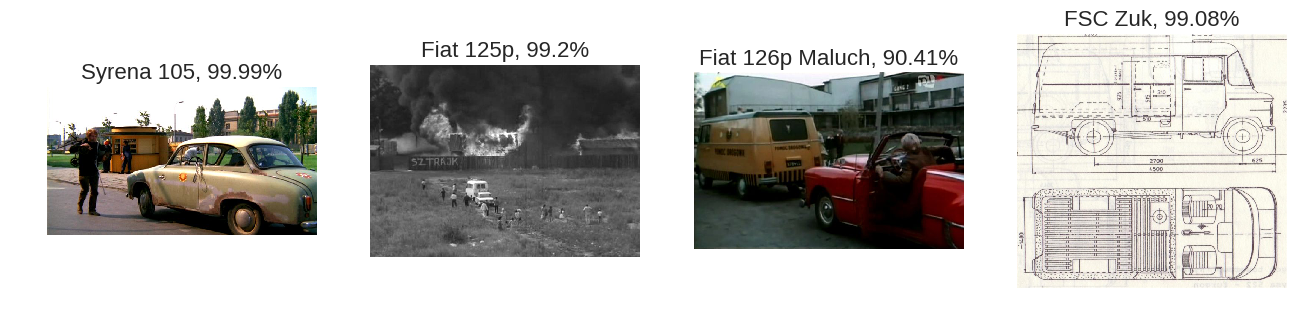

In [55]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * pred_probs[idxs, 1])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==selected_cat_idx)==is_correct else 1
    return most_by_mask((preds == selected_y)==is_correct & (selected_y == y), mult)

Most correct ZSD Nysa
['ZSD.Nysa.521.000461 -> ZSD Nysa, 100.0%', 'ZSD.Nysa.521.000528 -> ZSD Nysa, 100.0%', 'ZSD.Nysa.1.19_1487454874.6 -> ZSD Nysa, 100.0%', 'ZSD.Nysa.501.000144 -> ZSD Nysa, 100.0%']


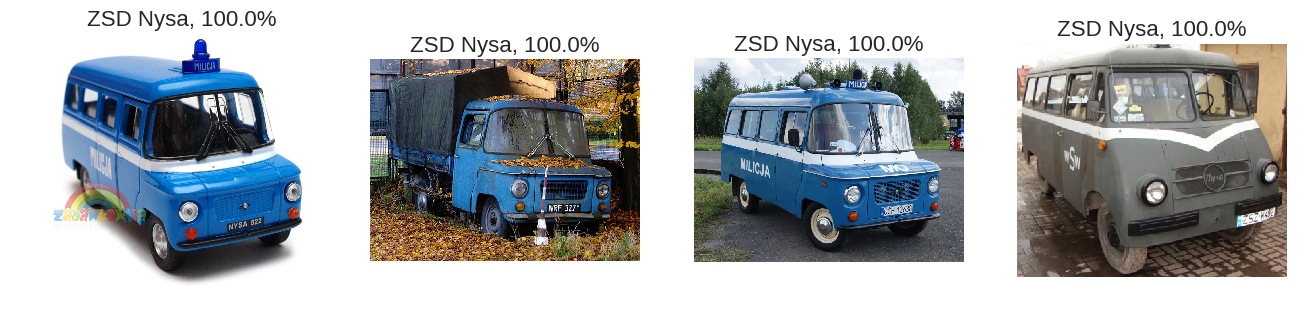

In [52]:
plot_val_with_title(most_by_correct(selected_cat_idx, True), "Most correct " + selected_cat)

Most incorrect ZSD Nysa
['ZSD.Nysa.521.000555 -> Autobus Jelcz Ogorek, 21.61%', 'ZSD.Nysa.501.000183 -> Autobus Jelcz Ogorek, 28.32%', 'ZSD.Nysa.521.000079 -> Fiat 125p, 29.73%', 'ZSD.Nysa.501.000029 -> Syrena 105, 30.11%']


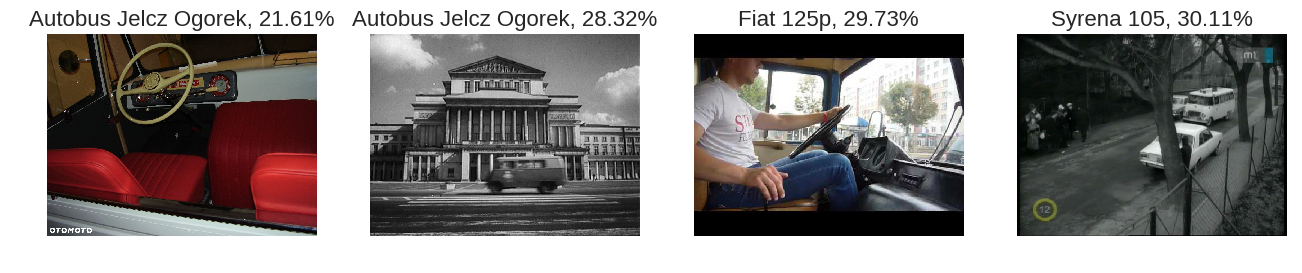

In [53]:
plot_val_with_title(most_by_correct(selected_cat_idx, False), "Most incorrect " + selected_cat)

Most uncertain predictions
['ZSD.Nysa.501.000081 -> Autobus Jelcz Ogorek, 49.11%', 'ZSD.Nysa.521.000232 -> ZSD Nysa, 49.08%', 'ZSD.Nysa.521.000332 -> FSO Polonez, 50.98%', 'ZSD.Nysa.521.000470 -> FSC Zuk, 51.1%']


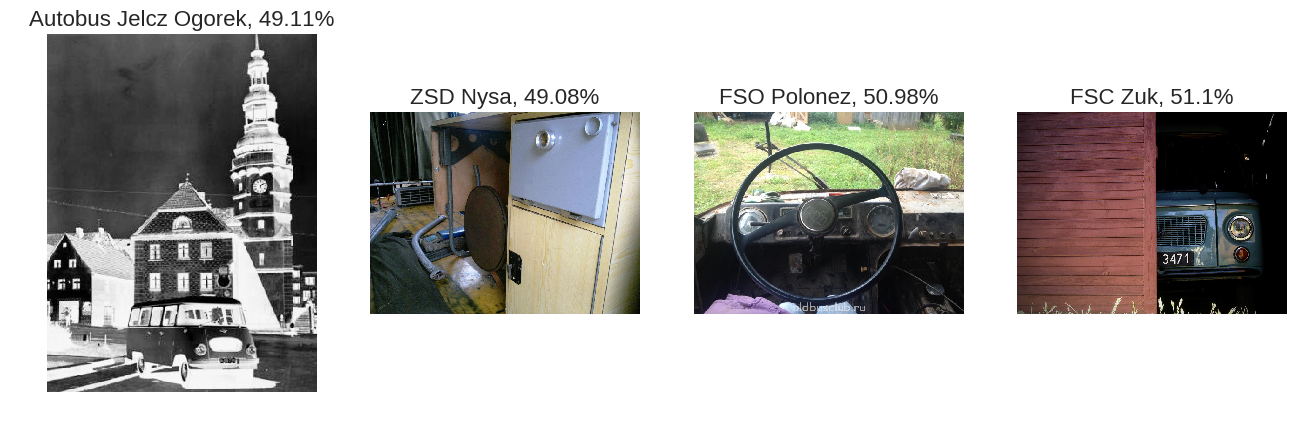

In [54]:
most_uncertain = np.argsort(np.abs(pred_probs[:, 1] -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")